In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [2]:
folder_names = glob.glob('../data/*')

In [3]:
folder_names

['../data/jikanwari',
 '../data/paper4',
 '../data/note2',
 '../data/bird',
 '../data/improc',
 '../data/computer',
 '../data/cpback',
 '../data/paper2',
 '../data/note4',
 '../data/nomigawa',
 '../data/shine',
 '../data/note1',
 '../data/craft',
 '../data/note5',
 '../data/note6',
 '../data/magazine',
 '../data/android',
 '../data/new',
 '../data/eyedrop',
 '../data/aless',
 '../data/tplink',
 '../data/mlbook',
 '../data/mlback',
 '../data/dvd',
 '../data/biology',
 '../data/note3',
 '../data/zoff',
 '../data/notefront',
 '../data/note7',
 '../data/paper3',
 '../data/comp_back',
 '../data/dlbook',
 '../data/AI',
 '../data/paper1',
 '../data/adv1',
 '../data/iphone']

In [4]:
def collect_data(folder_names):
    data = []
    labels = []
    metadata = []  # img_id, posnum
    global colnames
    for img_id, name in enumerate(folder_names):
        datafilename = name + '/data.csv'
        ansfilename =  name + '/ans.txt'
#         print(datafilename)
        if not os.path.exists(datafilename) or not os.path.exists(ansfilename):
            continue
        print(datafilename, ansfilename)
        d = pd.read_csv(datafilename)
        a = pd.read_csv(ansfilename, header=None).values.ravel()
        colnames = d.columns.values
        assert len(a) == 4, f"len(a) = {len(a)} (!= 4)"
        for row in d.values:
            label = 1 if row[0] in a else 0
            labels.append(label)
            metadata.append((img_id, row[1]))
            data.append(row[2:])
    return np.array(data), np.array(labels), np.array(metadata)

In [5]:
colnames = []

In [6]:
data, labels, metadata = collect_data(folder_names)

../data/note2/data.csv ../data/note2/ans.txt
../data/bird/data.csv ../data/bird/ans.txt
../data/improc/data.csv ../data/improc/ans.txt
../data/computer/data.csv ../data/computer/ans.txt
../data/cpback/data.csv ../data/cpback/ans.txt
../data/paper2/data.csv ../data/paper2/ans.txt
../data/note4/data.csv ../data/note4/ans.txt
../data/nomigawa/data.csv ../data/nomigawa/ans.txt
../data/shine/data.csv ../data/shine/ans.txt
../data/note1/data.csv ../data/note1/ans.txt
../data/craft/data.csv ../data/craft/ans.txt
../data/note5/data.csv ../data/note5/ans.txt
../data/note6/data.csv ../data/note6/ans.txt
../data/magazine/data.csv ../data/magazine/ans.txt
../data/android/data.csv ../data/android/ans.txt
../data/eyedrop/data.csv ../data/eyedrop/ans.txt
../data/aless/data.csv ../data/aless/ans.txt
../data/tplink/data.csv ../data/tplink/ans.txt
../data/mlbook/data.csv ../data/mlbook/ans.txt
../data/mlback/data.csv ../data/mlback/ans.txt
../data/dvd/data.csv ../data/dvd/ans.txt
../data/biology/data.cs

In [7]:
colnames

array(['id', 'posnum', 'seglen_hor', 'seglen_ver', 'segdist_hor',
       'segdist_ver', 'segdeg_hor', 'segdeg_ver', 'cross_deg', 'dist_hor',
       'dist_ver'], dtype=object)

In [8]:
print(len(labels), sum(labels))

3631 122


In [9]:
feature_dict = {colnames[i+2]: i for i in range(len(colnames)-2)}
feature_dict

{'seglen_hor': 0,
 'seglen_ver': 1,
 'segdist_hor': 2,
 'segdist_ver': 3,
 'segdeg_hor': 4,
 'segdeg_ver': 5,
 'cross_deg': 6,
 'dist_hor': 7,
 'dist_ver': 8}

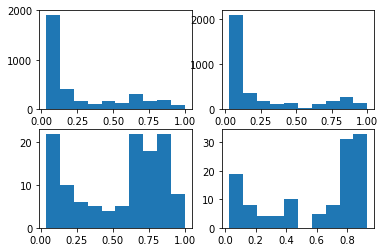

In [10]:
plt.subplot(2, 2, 1)
plt.hist(data[:, feature_dict['seglen_hor']])
plt.subplot(2, 2, 2)
plt.hist(data[:, feature_dict['seglen_ver']])
plt.subplot(2, 2, 3)
plt.hist(data[labels==1, feature_dict['seglen_hor']])
plt.subplot(2, 2, 4)
plt.hist(data[labels==1, feature_dict['seglen_ver']])
plt.show()

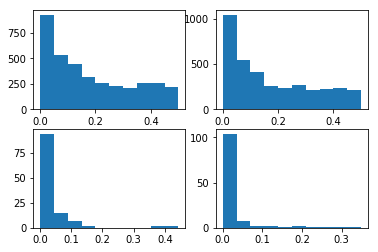

In [11]:
plt.subplot(2, 2, 1)
plt.hist(data[:, feature_dict['segdist_hor']])
plt.subplot(2, 2, 2)
plt.hist(data[:, feature_dict['segdist_ver']])
plt.subplot(2, 2, 3)
plt.hist(data[labels==1, feature_dict['segdist_hor']])
plt.subplot(2, 2, 4)
plt.hist(data[labels==1, feature_dict['segdist_ver']])
plt.show()

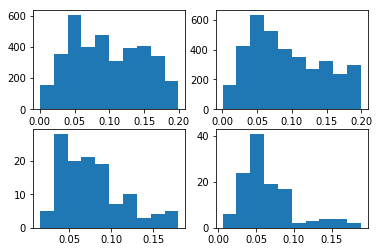

In [12]:
plt.subplot(2, 2, 1)
plt.hist(data[:, feature_dict['dist_hor']])
plt.subplot(2, 2, 2)
plt.hist(data[:, feature_dict['dist_ver']])
plt.subplot(2, 2, 3)
plt.hist(data[labels==1, feature_dict['dist_hor']])
plt.subplot(2, 2, 4)
plt.hist(data[labels==1, feature_dict['dist_ver']])
plt.show()

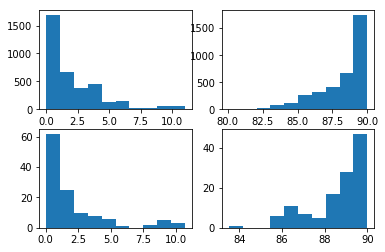

In [13]:
plt.subplot(2, 2, 1)
plt.hist(data[:, feature_dict['segdeg_hor']] * 180 / np.pi)
plt.subplot(2, 2, 2)
plt.hist(data[:, feature_dict['segdeg_ver']] * 180 / np.pi)
plt.subplot(2, 2, 3)
plt.hist(data[labels==1, feature_dict['segdeg_hor']] * 180 / np.pi)
plt.subplot(2, 2, 4)
plt.hist(data[labels==1, feature_dict['segdeg_ver']] * 180 / np.pi)
plt.show()

In [14]:
data_train = []
data_test = []
labels_train = []
labels_test = []
metadata_train = []
metadata_test = []

In [15]:
import random

def split_data():
    global data_train
    global data_test
    global labels_train
    global labels_test
    global metadata_train
    global metadata_test
    data_train = []
    data_test = []
    labels_train = []
    labels_test = []
    metadata_train = []
    metadata_test = []
    img_indice = range(len(folder_names))
    img_indice_train = random.sample(img_indice, int(len(img_indice) * 0.7))
    # split data (don't split image)
    for i in range(len(data)):
        if metadata[i][0] in img_indice_train:
            data_train.append(data[i])
            labels_train.append(labels[i])
            metadata_train.append(metadata[i])
        else:
            data_test.append(data[i])
            labels_test.append(labels[i])
            metadata_test.append(metadata[i])
    data_train = np.array(data_train)
    data_test = np.array(data_test)
    labels_train = np.array(labels_train)
    labels_test = np.array(labels_test)
    metadata_train = np.array(metadata_train)
    metadata_test = np.array(metadata_test)
    print(f"train_imgs: {len(img_indice_train)}, test_imgs: {len(img_indice) - len(img_indice_train)}")
    print(f"labels_train: {len(labels_train)}, {sum(labels_train)}")
    print(f"labels_test: {len(labels_test)}, {sum(labels_test)}")

In [16]:
split_data()

train_imgs: 25, test_imgs: 11
labels_train: 2466, 82
labels_test: 1165, 40


## PCA

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_train)
transformed_train = pca.fit_transform(data_train)
transformed_test = pca.transform(data_test)

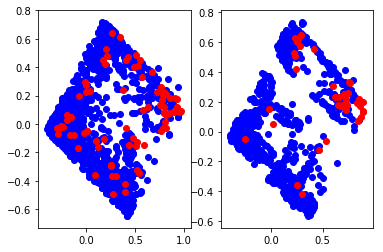

In [18]:
plt.subplot(1, 2, 1)
plt.scatter(transformed_train[labels_train==0][:,0], transformed_train[labels_train==0][:,1], c='blue')
plt.scatter(transformed_train[labels_train==1][:,0], transformed_train[labels_train==1][:,1], c='red')
plt.subplot(1, 2, 2)
plt.scatter(transformed_test[labels_test==0][:,0], transformed_test[labels_test==0][:,1], c='blue')
plt.scatter(transformed_test[labels_test==1][:,0], transformed_test[labels_test==1][:,1], c='red')
plt.show()

In [19]:
def rank_accuracy(true_labels, pred_vals, metadata, n_tol=3):
    positive_vals = pred_vals
    if pred_vals.ndim == 2:  # case of predict_proba
        positive_vals = pred_vals[:, 1]
    indice = np.argsort(positive_vals)[::-1]  # descending order
    err_count = {}
    errors = []
    corrects = []
    for idx in indice:
        md = tuple(metadata[idx])
        if not md in err_count:
            err_count[md] = 0
        if md in corrects or md in errors:  # already decided
            continue
        if true_labels[idx] == 1:  # correct classification
            corrects.append(md)
        else:
            err_count[md] += 1  # wrong classfication
            if err_count[md] >= n_tol:
                errors.append(md)
    
    return len(corrects) / len(err_count)

## Pipeline

In [124]:
split_data()

train_imgs: 25, test_imgs: 11
labels_train: 2315, 86
labels_test: 1316, 36


In [161]:
from sklearn.preprocessing import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.pipeline import Pipeline

stdsc = StandardScaler()
brf = BalancedRandomForestClassifier(n_estimators=100, class_weight={0:1, 1:1}, n_jobs=-1)
steps = [
    ('stdsc', stdsc),
    ('brf', brf)
]
pipeline = Pipeline(steps)

In [162]:
pipeline.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('brf', BalancedRandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
       ...te=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False))])

In [163]:
pred_train = pipeline.predict(data_train)
pred_test = pipeline.predict(data_test)

In [164]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_train, pred_train))
print(confusion_matrix(labels_test, pred_test))

[[1959  216]
 [   2   84]]
[[1199  135]
 [   8   28]]


In [165]:
proba_train = pipeline.predict_proba(data_train)
proba_test = pipeline.predict_proba(data_test)

In [166]:
print(rank_accuracy(labels_train, proba_train, metadata_train, n_tol=2))
print(rank_accuracy(labels_test, proba_test, metadata_test, n_tol=2))

0.9529411764705882
0.75


## Feature Importances

In [136]:
importances = pipeline.named_steps.brf.feature_importances_
indice = np.argsort(importances)

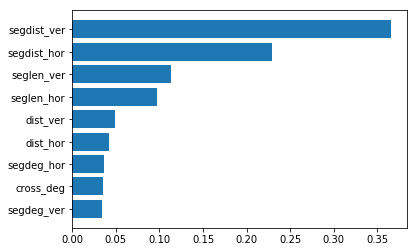

In [142]:
features = colnames[indice+2]
plt.barh(features, importances[indice])
plt.yticks(features)
plt.show()

## Grid Search

In [156]:
split_data()

train_imgs: 25, test_imgs: 11
labels_train: 2261, 86
labels_test: 1370, 36


In [157]:
from sklearn.model_selection import GridSearchCV
params = {
    'brf__max_features': [1, 'auto', None],
    'brf__max_depth': [1, 5, None],
    'brf__min_samples_leaf': [1, 2, 4]
}
gs = GridSearchCV(pipeline, params, cv=3)
gs.fit(data_train, labels_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('brf', BalancedRandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
       ...te=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'brf__max_features': [1, 'auto', None], 'brf__max_depth': [1, 5, None], 'brf__min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [158]:
print(gs.best_params_)
clf = gs.best_estimator_

{'brf__max_depth': None, 'brf__max_features': 1, 'brf__min_samples_leaf': 1}


In [159]:
from sklearn.metrics import confusion_matrix
pred_train = clf.predict(data_train)
pred_test = clf.predict(data_test)
print(confusion_matrix(labels_train, pred_train))
print(confusion_matrix(labels_test, pred_test))

[[1973  202]
 [   0   86]]
[[1193  141]
 [   7   29]]


In [160]:
proba_train = pipeline.predict_proba(data_train)
proba_test = pipeline.predict_proba(data_test)
print(rank_accuracy(labels_train, proba_train, metadata_train, n_tol=2))
print(rank_accuracy(labels_test, proba_test, metadata_test, n_tol=2))

0.9647058823529412
0.8055555555555556


## Save Model

In [167]:
import pickle
model = clf
model.fit(data, labels)
with open('../ml_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [25]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
data_train = stdsc.fit_transform(data_train)
data_test = stdsc.transform(data_test)

In [95]:
print(len(img_indice), len(img_indice_train))

25 17


## simple SVM

In [38]:
split_data()

train_imgs: 25, test_imgs: 11
labels_train: 1907, 78
labels_test: 1724, 44


In [42]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
svm = SVC(gamma='auto', class_weight={0: 1, 1: 100})
svm.fit(data_train, labels_train)

SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 100}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
print(svm.score(data_train, labels_train))
print(svm.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm.predict(data_train)))
print(confusion_matrix(labels_test, svm.predict(data_test)))
print(rank_accuracy(labels_train, svm.decision_function(data_train), metadata_train, n_tol=1))
print(rank_accuracy(labels_test, svm.decision_function(data_test), metadata_test, n_tol=2))

0.7446250655479811
0.7430394431554525
[[1344  485]
 [   2   76]]
[[1244  436]
 [   7   37]]
0.7532467532467533
0.75


## SVM with random over sampling

In [44]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(0.5)
data_ros, labels_ros = ros.fit_resample(data_train, labels_train)
print(sorted(Counter(labels_ros).items()))

svm_ros = SVC(gamma='auto')
svm_ros.fit(data_ros, labels_ros)

[(0, 1829), (1, 914)]


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
print(svm_ros.score(data_train, labels_train))
print(svm_ros.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_ros.predict(data_train)))
print(confusion_matrix(labels_test, svm_ros.predict(data_test)))
print(rank_accuracy(labels_train, svm_ros.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_ros.decision_function(data_test), metadata_test, n_tol=2))

0.8993183009963294
0.9153132250580046
[[1649  180]
 [  12   66]]
[[1548  132]
 [  14   30]]
0.7922077922077922
0.6136363636363636


## SVM with SMOTE

In [46]:
from imblearn.over_sampling import SMOTE
data_smote, labels_smote = SMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_smote == 0), sum(labels_smote == 1))

svm_smote = SVC(gamma='auto')
svm_smote.fit(data_smote, labels_smote)

1829 914


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
print(svm_smote.score(data_train, labels_train))
print(svm_smote.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_smote.predict(data_train)))
print(confusion_matrix(labels_test, svm_smote.predict(data_test)))
print(rank_accuracy(labels_train, svm_smote.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_smote.decision_function(data_test), metadata_test, n_tol=2))

0.8982695332983744
0.9170533642691415
[[1647  182]
 [  12   66]]
[[1551  129]
 [  14   30]]
0.7922077922077922
0.6818181818181818


## SVM with ADASYN

In [48]:
from imblearn.over_sampling import ADASYN
data_ada, labels_ada = ADASYN(0.5).fit_resample(data_train, labels_train)
print(sum(labels_ada == 0), sum(labels_ada == 1))

svm_ada = SVC(gamma='auto')
svm_ada.fit(data_ada, labels_ada)

1829 919


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
print(svm_ada.score(data_train, labels_train))
print(svm_ada.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_ada.predict(data_train)))
print(confusion_matrix(labels_test, svm_ada.predict(data_test)))
print(rank_accuracy(labels_train, svm_ada.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_ada.decision_function(data_test), metadata_test, n_tol=2))

0.8741478762454117
0.894431554524362
[[1593  236]
 [   4   74]]
[[1508  172]
 [  10   34]]
0.8181818181818182
0.7045454545454546


## SVM with BorderlineSMOTE

In [50]:
from imblearn.over_sampling import BorderlineSMOTE
data_bsmote, labels_bsmote = BorderlineSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_bsmote == 0), sum(labels_bsmote == 1))

svm_bsmote = SVC(gamma='auto')
svm_bsmote.fit(data_bsmote, labels_bsmote)

1829 914


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
print(svm_bsmote.score(data_train, labels_train))
print(svm_bsmote.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_bsmote.predict(data_train)))
print(confusion_matrix(labels_test, svm_bsmote.predict(data_test)))
print(rank_accuracy(labels_train, svm_bsmote.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_bsmote.decision_function(data_test), metadata_test, n_tol=2))

0.8867330886208705
0.9077726218097448
[[1621  208]
 [   8   70]]
[[1532  148]
 [  11   33]]
0.7922077922077922
0.7045454545454546


## SVM with SVMSMOTE

In [52]:
from imblearn.over_sampling import SVMSMOTE
data_svm, labels_svm = SVMSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_svm == 0), sum(labels_svm == 1))

svm_ss = SVC(gamma='auto')
svm_ss.fit(data_svm, labels_svm)

1829 914


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
print(svm_ss.score(data_train, labels_train))
print(svm_ss.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_ss.predict(data_train)))
print(confusion_matrix(labels_test, svm_ss.predict(data_test)))
print(rank_accuracy(labels_train, svm_ss.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_ss.decision_function(data_test), metadata_test, n_tol=2))

0.9124278972207656
0.929814385150812
[[1680  149]
 [  18   60]]
[[1578  102]
 [  19   25]]
0.7532467532467533
0.5909090909090909


## SVM with ClusterCentroids (k-means)

In [181]:
from imblearn.under_sampling import ClusterCentroids
data_cc, labels_cc = ClusterCentroids(0.5).fit_resample(data_train, labels_train)
print(sum(labels_cc == 0), sum(labels_cc == 1))

svm_cc = SVC(gamma='auto')
svm_cc.fit(data_cc, labels_cc)

260 130


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [182]:
print(svm_cc.score(data_train, labels_train))
print(svm_cc.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_cc.predict(data_train)))
print(confusion_matrix(labels_test, svm_cc.predict(data_test)))
print(rank_accuracy(labels_train, svm_cc.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_cc.decision_function(data_test), metadata_test, n_tol=2))

0.94358355757632
0.9298097251585624
[[10046   601]
 [    7   123]]
[[4341  330]
 [   2   57]]
0.8939393939393939
0.7833333333333333


## SVM with RandomUnderSampler

In [183]:
from imblearn.under_sampling import RandomUnderSampler
data_rus, labels_rus = RandomUnderSampler(0.5, replacement=True).fit_resample(data_train, labels_train)
print(sum(labels_rus == 0), sum(labels_rus == 1))

svm_rus = SVC(gamma='auto')
svm_rus.fit(data_rus, labels_rus)

260 130


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [184]:
print(svm_rus.score(data_train, labels_train))
print(svm_rus.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_rus.predict(data_train)))
print(confusion_matrix(labels_test, svm_rus.predict(data_test)))
print(rank_accuracy(labels_train, svm_rus.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_rus.decision_function(data_test), metadata_test, n_tol=2))

0.9403359005289041
0.9255813953488372
[[10010   637]
 [    6   124]]
[[4321  350]
 [   2   57]]
0.8636363636363636
0.7666666666666667


## SVM with SMOTETomek

In [200]:
from imblearn.combine import SMOTETomek
data_st, labels_st = SMOTETomek(0.5).fit_resample(data_train, labels_train)
print(sum(labels_st == 0), sum(labels_st == 1))

svm_st = SVC(gamma='auto')
svm_st.fit(data_st, labels_st)

10647 5323


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [201]:
sum(labels_train == 0)

10647

In [202]:
print(svm_st.score(data_train, labels_train))
print(svm_st.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_st.predict(data_train)))
print(confusion_matrix(labels_test, svm_st.predict(data_test)))
print(rank_accuracy(labels_train, svm_st.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_st.decision_function(data_test), metadata_test, n_tol=2))

0.9702143453651294
0.9562367864693446
[[10329   318]
 [    3   127]]
[[4468  203]
 [   4   55]]
0.9318181818181818
0.8166666666666667


## SVM with SMOTEEN

In [54]:
from imblearn.combine import SMOTEENN
data_stee, labels_stee = SMOTEENN(0.5).fit_resample(data_train, labels_train)
print(sum(labels_stee == 0), sum(labels_stee == 1))

svm_stee = SVC(gamma='auto')
svm_stee.fit(data_stee, labels_stee)

1651 884


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
print(svm_stee.score(data_train, labels_train))
print(svm_stee.score(data_test, labels_test))
print(confusion_matrix(labels_train, svm_stee.predict(data_train)))
print(confusion_matrix(labels_test, svm_stee.predict(data_test)))
print(rank_accuracy(labels_train, svm_stee.decision_function(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, svm_stee.decision_function(data_test), metadata_test, n_tol=2))

0.8762454116413214
0.8979118329466357
[[1599  230]
 [   6   72]]
[[1514  166]
 [  10   34]]
0.7922077922077922
0.7045454545454546


## RandomForest with BoarderlineSmote

In [62]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import BorderlineSMOTE
data_bsmote, labels_bsmote = BorderlineSMOTE(0.5).fit_resample(data_train, labels_train)
print(sum(labels_bsmote == 0), sum(labels_bsmote == 1))

forest_bs = RandomForestClassifier(n_estimators=100)
forest_bs.fit(data_bsmote, labels_bsmote)

2881 1440


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
print(forest_bs.score(data_train, labels_train))
print(forest_bs.score(data_test, labels_test))
print(confusion_matrix(labels_train, forest_bs.predict(data_train)))
print(confusion_matrix(labels_test, forest_bs.predict(data_test)))
print(rank_accuracy(labels_train, forest_bs.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, forest_bs.predict_proba(data_test), metadata_test, n_tol=2))

1.0
0.9625748502994012
[[2881    0]
 [   0   82]]
[[620   8]
 [ 17  23]]
0.9382716049382716
0.85


In [64]:
from sklearn.model_selection import GridSearchCV
forest_params = {
    'max_features': [1, 'auto', None],
    'max_depth': [1, 5, None],
    'min_samples_leaf': [1, 2, 4]
}
gs_forest = GridSearchCV(RandomForestClassifier(n_estimators=100), forest_params, cv=5)
gs_forest.fit(data_bsmote, labels_bsmote)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [1, 'auto', None], 'max_depth': [1, 5, None], 'min_samples_leaf': [1, 2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
print(gs_forest.best_params_)

{'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1}


In [68]:
forest = gs_forest.best_estimator_
print(forest.score(data_train, labels_train))
print(forest.score(data_test, labels_test))
print(confusion_matrix(labels_train, forest.predict(data_train)))
print(confusion_matrix(labels_test, forest.predict(data_test)))
print(rank_accuracy(labels_train, forest.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, forest.predict_proba(data_test), metadata_test, n_tol=2))

1.0
0.9550898203592815
[[2881    0]
 [   0   82]]
[[621   7]
 [ 23  17]]
0.9382716049382716
0.9


## Blanced Bagging classifier

In [262]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                 sampling_strategy='auto',
                                 replacement=False,
                                 n_estimators=100)
bbc.fit(data_train, labels_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
             random_state=None, ratio=None, replacement=False,
             sampling_strategy='auto', verbose=0, warm_start=False)

In [263]:
print(bbc.score(data_train, labels_train))
print(bbc.score(data_test, labels_test))
print(confusion_matrix(labels_train, bbc.predict(data_train)))
print(confusion_matrix(labels_test, bbc.predict(data_test)))
print(rank_accuracy(labels_train, bbc.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, bbc.predict_proba(data_test), metadata_test, n_tol=2))

0.955116164112704
0.9541913946587537
[[9531  454]
 [   0  130]]
[[5087  246]
 [   1   58]]
0.946969696969697
0.8666666666666667


## Balanced RandomForest Classifier

In [52]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100)
brf.fit(data_train, labels_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [53]:
print(brf.score(data_train, labels_train))
print(brf.score(data_test, labels_test))
print(confusion_matrix(labels_train, brf.predict(data_train)))
print(confusion_matrix(labels_test, brf.predict(data_test)))
print(rank_accuracy(labels_train, brf.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, brf.predict_proba(data_test), metadata_test, n_tol=2))

0.9576158940397351
0.9554455445544554
[[11438   510]
 [    2   130]]
[[4956  231]
 [   3   62]]
0.9621212121212122
0.8676470588235294


## Boosting

In [143]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=100)
rusboost.fit(data_train, labels_train)

RUSBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None,
          replacement=False, sampling_strategy='auto')

In [144]:
print(rusboost.score(data_train, labels_train))
print(rusboost.score(data_test, labels_test))
print(confusion_matrix(labels_train, rusboost.predict(data_train)))
print(confusion_matrix(labels_test, rusboost.predict(data_test)))
print(rank_accuracy(labels_train, rusboost.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, rusboost.predict_proba(data_test), metadata_test, n_tol=2))

0.9935205183585313
0.9741641337386018
[[2214   15]
 [   0   86]]
[[1264   16]
 [  18   18]]
0.9411764705882353
0.8055555555555556


In [154]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, n_jobs=-1)
eec.fit(data_train, labels_train)

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=-1,
            random_state=None, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)

In [155]:
print(eec.score(data_train, labels_train))
print(eec.score(data_test, labels_test))
print(confusion_matrix(labels_train, eec.predict(data_train)))
print(confusion_matrix(labels_test, eec.predict(data_test)))
print(rank_accuracy(labels_train, eec.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, eec.predict_proba(data_test), metadata_test, n_tol=2))

0.882890365448505
0.8372853638593623
[[2044  282]
 [   0   82]]
[[985 198]
 [  1  39]]
0.8765432098765432
0.9


## Probability Calibration

In [37]:
from sklearn.calibration import CalibratedClassifierCV
cc = CalibratedClassifierCV(BalancedRandomForestClassifier(), cv=5)
cc.fit(data_train, labels_train)

CalibratedClassifierCV(base_estimator=BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=None, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [39]:
print(cc.score(data_train, labels_train))
print(cc.score(data_test, labels_test))
print(confusion_matrix(labels_train, cc.predict(data_train)))
print(confusion_matrix(labels_test, cc.predict(data_test)))
print(rank_accuracy(labels_train, cc.predict_proba(data_train), metadata_train, n_tol=2))
print(rank_accuracy(labels_test, cc.predict_proba(data_test), metadata_test, n_tol=2))

0.993046357615894
0.9891469916222392
[[11936    12]
 [   72    60]]
[[5175   12]
 [  45   20]]
0.9393939393939394
0.8823529411764706
